In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors, collections
import matplotlib.patheffects as pe
print(os.getcwd())

# PyDMD imports
from pydmd import DMD, MrDMD, FbDMD, SpDMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D, plot_eigs_mrdmd

%matplotlib widget

save = False
plotting = True

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves


In [2]:
print(base_dir)

#Load simulation data
u, v, w, b, phi, zeta, times = load_data('u_xz', 'v_xz', 'w_xz', 'th1_xz', 'th2_xz', 'omegaY_xz')
N_full = np.sqrt(np.gradient(b, gzf, axis=1))
N2t = np.gradient(np.gradient(b, gzf, axis=1), times, axis=0)
#b -= b[0] # subtract initial profile to get b'
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

/store/ATMOS/cwp29/data/waves/wide/hres/N_1/
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>


/tmp/ipykernel_702933/357467318.py:5: RuntimeWarning: invalid value encountered in sqrt
  N_full = np.sqrt(np.gradient(b, gzf, axis=1))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


(156, 513, 1024)
Plume penetration occured at t=2.3545


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [3]:
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per
tend_idx = len(times)-1
tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))

25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods


In [4]:
#extract turbulent components
u_az, v_az, w_az, b_az = load_az_data('u_az', 'v_az', 'w_az', 'b_az')

u_mean = np.concatenate((np.flip(u_az, axis=2), u_az), axis=2)
v_mean = np.concatenate((np.flip(v_az, axis=2), v_az), axis=2)
w_mean = np.concatenate((np.flip(w_az, axis=2), w_az), axis=2)
b_mean = np.concatenate((np.flip(b_az, axis=2), b_az), axis=2)

u -= u_mean
v -= v_mean
w -= w_mean
b -= b_mean

Az keys: <KeysViewHDF5 ['b_az', 'bb_sfluc', 'p_az', 'th_az', 'u_az', 'ub_sfluc', 'uth_sfluc', 'uu_sfluc', 'uv_sfluc', 'uw_sfluc', 'v_az', 'vv_sfluc', 'vw_sfluc', 'w_az', 'wb_sfluc', 'ww_sfluc']>


In [5]:
# characteristic spectra
omega_c = 0.39
k_xc = 23.9

#zplot = 0.4
zmin = 0.27
zmax = 0.45
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)
gz_trunc = gz[zmin_idx-1:zmax_idx+1]
gzf_trunc = gzf[zmin_idx:zmax_idx+1]

xmin = 0.3
xmax = 0.7
xlims = (xmin, xmax)
xmin_idx = get_index(xmin, gxf)
xmax_idx = get_index(xmax, gxf)
gx_trunc = gx[xmin_idx-1:xmax_idx+1]
gxf_trunc = gxf[xmin_idx:xmax_idx+1]

zplot = 0.4 # must be smaller than z_max
xplot = 0.65 # must be smaller than x_max
assert zplot <= zmax


phi_contour = 1e-3
clim = 1e-3

# Choose data window
u = u[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
v = v[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
zeta = zeta[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
N2t = N2t[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
filter_step = 1
times = times[::filter_step]
times_trunc = np.concatenate(([times[0]-filter_step*md['SAVE_STATS_DT_FINE']], times))
ntimes = len(times)

print(len(times))

phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]

X, Y = np.meshgrid(gx[xmin_idx-1:xmax_idx+1], gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf[xmin_idx:xmax_idx+1], gzf[zmin_idx:zmax_idx+1])

150


In [6]:
# Set up FT arrays
freq_m = -np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
wavenumber_z = np.fft.fftfreq(w.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = np.fft.fftfreq(w.shape[2])*2*np.pi*md['Nx']/md['LX']

In [7]:
# Pre-processing & data array setup
data_pack = [u, v, w, b, zeta]
data_orig = np.array(data_pack)
data_orig = np.moveaxis(data_orig, 0, -1)

plot_idx = 1

for i in range(len(data_pack)):
    var = data_pack[i]
    
    # Gaussian filtering
    sigma = 2
    var_filtered = np.zeros_like(var)
    for j in range(len(var)):
        var_filtered[j] = ndimage.gaussian_filter(var[j], sigma)

    # Hilbert transform
    # Dimension sizes from large to small: x, z, t

    # FFT in x
    waves_x = np.fft.fft(var_filtered, axis=2)
    waves_x[:, :, np.abs(wavenumber_x) >= 1000] = 0 #remove small wavelength oscillations
    waves_filtered = np.fft.ifft(waves_x, axis=2)

    # FFT in z
    waves_z = np.fft.fft(waves_filtered, axis=1)
    #waves_z[:, wavenumber_z >= 0, :] = 0 #remove upward propagating waves
    waves_filtered = np.fft.ifft(waves_z, axis=1)
    
    waves_t = np.fft.fft(waves_filtered, axis=0)
    #waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
    #waves_t *= 2 # preserve energy
    waves_filtered = np.real(np.fft.ifft(waves_t, axis=0))

    data_pack[i] = waves_filtered

(4, 150, 155, 410)
(150, 155, 410, 4)


In [9]:
for i in range(4): # exclude zeta from turbulent component extraction
    var_mean = np.mean(data_pack[i], axis=0)
    data_pack[i] -= var_mean

data = np.array(data_pack)
data = np.moveaxis(data, 0, -1)

In [8]:
snapshots = [data[::filter_step][i] for i in range(len(times))]
print(snapshots[0].shape)
print(len(snapshots))

(155, 410, 4)
150


In [9]:
dmd = DMD(svd_rank=-1)
dmd.fit(snapshots)

In [10]:
# Dump DMD info into arrays, then sort by frequency
dmd_eigs = dmd.eigs#/(md['SAVE_STATS_DT_FINE']*filter_step)
dmd_freqs = np.imag(np.log(dmd_eigs)/(md['SAVE_STATS_DT_FINE']*filter_step))/np.sqrt(md['N2'])
dmd_amps = dmd.amplitudes
dmd_svd = np.linalg.svd(dmd.snapshots, full_matrices=False, compute_uv=False)
dmd_svar = dmd_svd * 100/np.sum(dmd_svd)
dmd_modes = np.moveaxis(dmd.modes, -1, 0)
dmd_dynamics = dmd.dynamics

# Sorting
sort_indices = np.argsort(np.abs(dmd_freqs))
#print(np.abs(dmd_freqs[sort_indices]))
dmd_eigs = dmd_eigs[sort_indices]
dmd_freqs = dmd_freqs[sort_indices]
dmd_amps = dmd_amps[sort_indices]
dmd_svd = dmd_svd[sort_indices]
dmd_svar = dmd_svar[sort_indices]
dmd_modes = dmd_modes[sort_indices]
dmd_dynamics = dmd_dynamics[sort_indices]

dmd_u_ids = np.where(dmd_freqs >= 0)[0] # indices for modes with positive freq.
dmd_cc_ids = np.zeros_like(dmd_u_ids) # indices for corresponding cc modes

dmd_ufreqs = dmd_freqs[dmd_u_ids]
dmd_umodes = dmd_modes[dmd_u_ids]

nmodes = len(dmd_freqs)
numodes = len(dmd_ufreqs)

for i in range(numodes):
    f = dmd_ufreqs[i]
    if -f not in dmd_freqs:
        dmd_cc_ids[i] = i
    else:
        dmd_cc_ids[i] = list(dmd_freqs).index(-f)


[0.         0.         0.         0.50710547 0.75946565]


/tmp/ipykernel_702933/3697490584.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  xs.append([x + dz*np.cos(theta)/np.sin(theta), z+dz])


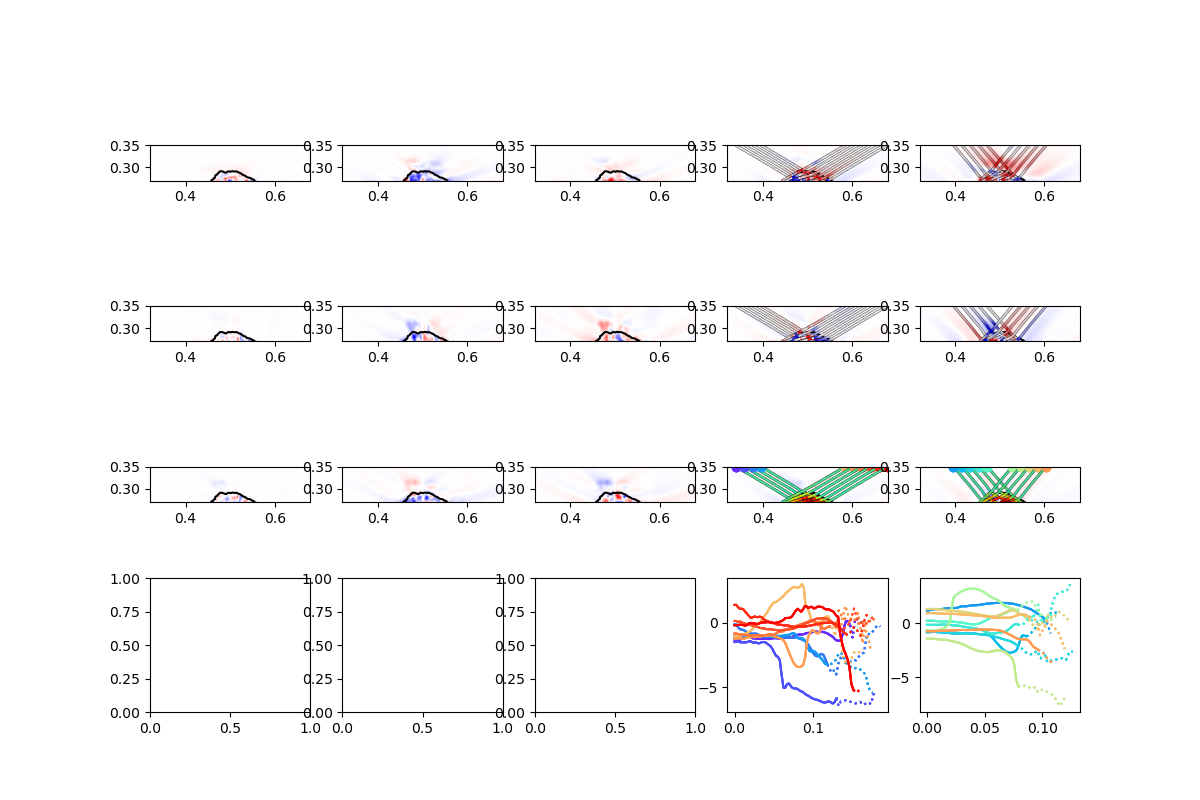

In [11]:
# Identify wave modes
dmd_w_ids = np.where(np.logical_and(0 <= dmd_ufreqs, dmd_ufreqs <= 1))[0]
nwmodes = len(dmd_w_ids)
print(dmd_ufreqs[dmd_w_ids])

# Set up for ray tracing
Nmean = np.nanmean(N_full, axis=0)
Ni = scipy.interpolate.RegularGridInterpolator((gzf, gxf), Nmean)
phimean = np.mean(phi_snapshots, axis=0)

start_points = np.linspace(0.32, 0.68, 20)
start_height = 0.35


fig, ax = plt.subplots(4, nwmodes, figsize=(12, 8))

for i in range(nwmodes):
    b_mode = np.real(dmd_umodes[dmd_w_ids[i]].reshape(snapshots[0].shape))[:,:,2]
    w_mode = np.real(dmd_umodes[dmd_w_ids[i]].reshape(snapshots[0].shape))[:,:,1]
    
    wi = scipy.interpolate.RegularGridInterpolator((gzf_trunc, gxf_trunc), w_mode)
    bi = scipy.interpolate.RegularGridInterpolator((gzf_trunc, gxf_trunc), b_mode)

    phii = scipy.interpolate.RegularGridInterpolator((gzf_trunc, gxf_trunc), phimean)

    for j in range(3):
        im = ax[j, i].pcolormesh(X, Y, np.real(dmd_umodes[dmd_w_ids[i]].reshape(snapshots[0].shape)[:,:,j+1]), cmap='bwr', norm=colors.CenteredNorm())
        ax[j, i].contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
        ax[j, i].set_aspect(1)

        ax[j, i].set_ylim(zmin, start_height)
        ax[j, i].set_xlim(start_points[0], start_points[-1])
    
    cols = plt.cm.rainbow(np.linspace(0, 1, len(start_points)))

    for xstart,c in zip(start_points, cols):
        x0 = [xstart, start_height]
        dz = -md['LZ']/md['Nz']
        N = np.sqrt(md['N2'])
        omega = dmd_ufreqs[dmd_w_ids[i]]*N
        flag = True
        
        xs = [x0]
        Ns = [Ni((start_height,xstart))]
        ws = [wi((start_height,xstart))]
        bs = [bi((start_height,xstart))]
        phis = [phii((start_height,xstart))]
        dist = [0]
    
        if xstart < md['LX']/2:
            thetas = [-np.arcsin(omega/N)]
        else:
            thetas = [np.arcsin(omega/N)]
            
        while flag:
            x = xs[-1][0]
            z = xs[-1][1]

            Npt = Ni((z, x))
            Ns.append(Npt)
            ws.append(wi((z,x)))
            bs.append(bi((z,x)))
            phis.append(phii((z,x)))
            if np.isnan(Npt):
                flag = False
            elif Npt < omega:
                thetas.append(0)
                xs.append([x, z+dz])
                dist.append(dist[-1]+np.sqrt(np.power(xs[-1][0]-xs[-2][0],2) + np.power(xs[-1][1]-xs[-2][1],2)))
            else:
                if thetas[-1] < 0:
                    thetas.append(-np.arcsin(omega/Npt))
                else:
                    thetas.append(np.arcsin(omega/Npt))
                    
                theta = thetas[-1]
            
                xs.append([x + dz*np.cos(theta)/np.sin(theta), z+dz])
                dist.append(dist[-1]+np.sqrt(np.power(xs[-1][0]-xs[-2][0],2) + np.power(xs[-1][1]-xs[-2][1],2)))
        
            if xs[-1][0] > xmax or xs[-1][0] < xmin:
                flag = False
            if xs[-1][1] > zmax or xs[-1][1] < zmin:
                flag = False
            if np.isnan(xs[-1][0]) or np.isnan(xs[-1][1]):
                flag = False
            if np.sqrt(np.power(xs[-1][0] - x, 2) + np.power(xs[-1][1] - z, 2)) < 1e-9:
                flag = False
        
        xs = np.array(xs)
        Ns = np.array(Ns)
        ws = np.array(ws)
        phis = np.array(phis)
        bs = np.array(bs)
        dist = np.array(dist)
        thetas = np.array(thetas)

        if len(np.argwhere(phis >= phi_contour)) > 0:
            pen_idx = np.min(np.argwhere(phis >= phi_contour))
        else:
            pen_idx = -1

        if pen_idx > 0:
            points = np.array([xs[:,0], xs[:,1]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
            phase = np.arctan((omega/np.power(Ns, 2)) * bs/ws)
    
            line_vars = [ws, bs, Ns]
            norms = [colors.CenteredNorm(),
                     colors.CenteredNorm(),
                     plt.Normalize(Nmean.min(), 0.5*Nmean.max())]
            for j in range(3):
                if j == 2:
                    lc = collections.LineCollection(segments, cmap='jet', norm=norms[j], path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
                else:
                    lc = collections.LineCollection(segments, cmap='bwr', norm=norms[j], path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        
                lc.set_array(line_vars[j])
                lc.set_linewidth(1.5)
                line = ax[j, i].add_collection(lc)
    
                if xstart == start_points[0]:
                    plt.colorbar(line, ax=ax[j, i])
    
                ax[3, i].plot(dist[:pen_idx], np.unwrap(phase, period=np.pi)[:pen_idx], color=c)
                ax[3, i].plot(dist[pen_idx-1:], np.unwrap(phase, period=np.pi)[pen_idx-1:], color=c, linestyle=':')
                ax[2, i].plot([xstart], [start_height], "o", color=c)